### Урок 5. #Задача оттока: варианты постановки, возможные способы решения##

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [8]:
gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Ананлогичный пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

In [9]:
tenure =  Pipeline([
                ('selector', NumberSelector(key='Tenure'))
            ])

tenure.fit(X_train)
tenure.transform(X_test).head(3)

,Tenure
9394,8
898,2
2398,8


Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [10]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [11]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [12]:
classifiers = [LogisticRegression(random_state = 42), RandomForestClassifier(max_depth=12, max_features=6, random_state=42),
              GradientBoostingClassifier (random_state=42)]
results = []

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

For LogisticRegression(random_state=42): precision=0.4624, recall=0.5677799607072691, roc_auc=0.7720774921330664, f_score=0.7720774921330664
Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


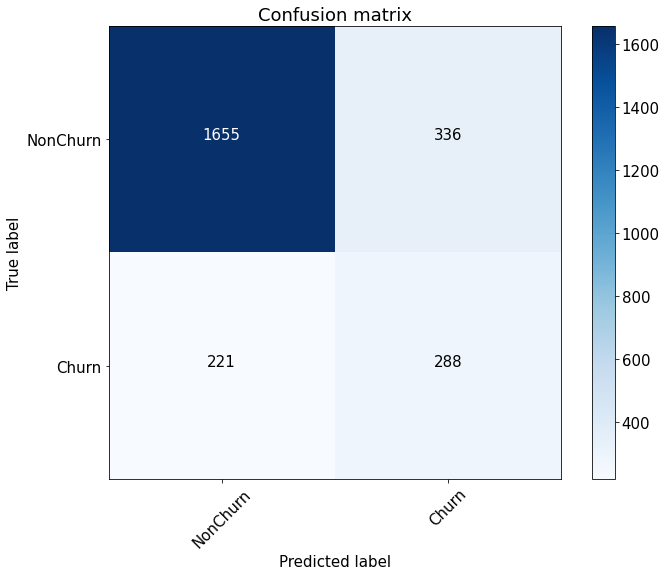

Economy result = -48
For RandomForestClassifier(max_depth=12, max_features=6, random_state=42): precision=0.6633466135458167, recall=0.6542239685658153, roc_auc=0.8721940283337889, f_score=0.8721940283337889
Confusion matrix, without normalization
[[1822  169]
 [ 177  332]]


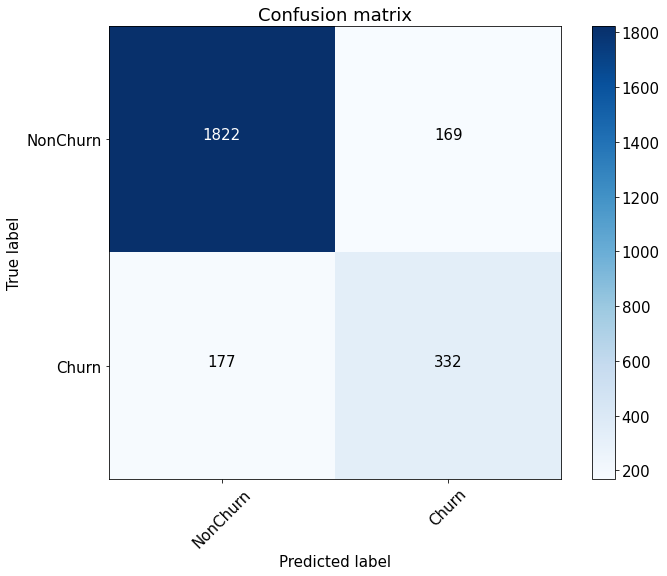

Economy result = 163
For GradientBoostingClassifier(random_state=42): precision=0.7037037037037037, recall=0.5972495088408645, roc_auc=0.8757458662211781, f_score=0.8757458662211781
Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


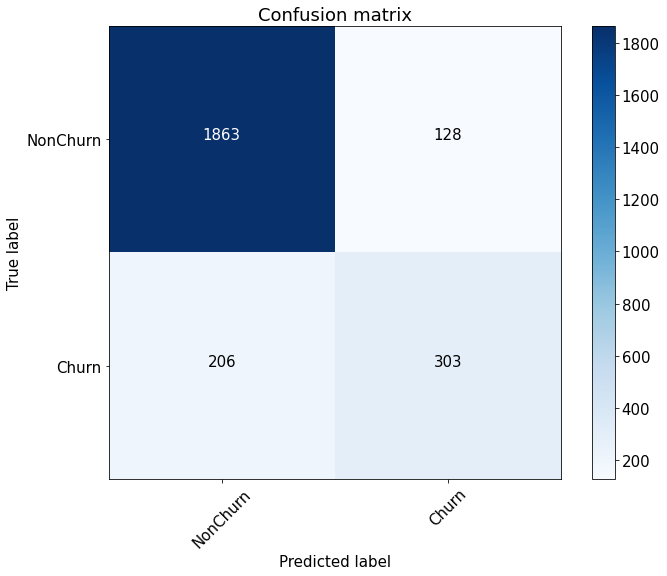

Economy result = 175


In [14]:
for classifier in classifiers:
    model = Pipeline([
        ('features', feats),
        ('classifier', classifier),
    ])

    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    b=1
    f_score = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    
    ix = np.argmax(f_score)
    
    f_score = f_score[ix]
    precision = precision[ix]
    recall = recall[ix]
    
    roc_auc = roc_auc_score(y_true=y_test, y_score=y_score)
    
    result = [classifier, precision, recall, roc_auc, f_score]
    results.append(result) 
    print(f'For {classifier}: precision={precision}, recall={recall}, roc_auc={roc_auc}, f_score={roc_auc}')
    
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
    plt.show()
    
    economy_result = 1 * cnf_matrix[1][1] - 1 * cnf_matrix[0][1]
    print(f'Economy result = {economy_result}')

In [15]:
df_results = pd.DataFrame(np.array(results),
                    columns=["model", "precision", "recall", "roc_auc", "f_score"])

df_results

,model,precision,recall,roc_auc,f_score
0,LogisticRegression(random_state=42),0.4624,0.56778,0.772077,0.5097
1,"(DecisionTreeClassifier(max_depth=12, max_feat...",0.663347,0.654224,0.872194,0.658754
2,([DecisionTreeRegressor(criterion='friedman_ms...,0.703704,0.59725,0.875746,0.646121


<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Ваш ответ здесь: 

Судя по получившимя результатам - экономически более целесообразно использование Судя по получившимя результатам - экономически более целесообразно использование GradientBoostingClassifier, тк в нем меньше число FP, а значит стоит ориентироваться на precision, а не recall

In [16]:
pipeline = Pipeline([
        ('features', feats),
        ('classifier', GradientBoostingClassifier (random_state=42)),
    ])

In [17]:
from sklearn.model_selection import GridSearchCV

params={'classifier__learning_rate':[0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
        'classifier__min_samples_split':[0.1, 0.5, 12],
        'classifier__min_samples_leaf':[0.1, 0.5, 12],
        'classifier__max_depth':[3, 5, 8],
        'classifier__max_features':["log2","sqrt"],
        'classifier__criterion':["friedman_mse",  "mae"],
        'classifier__subsample':[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
        'classifier__n_estimators':[10]
        }

Запускаем перебор

In [18]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__criterion': 'friedman_mse',
 'classifier__learning_rate': 0.2,
 'classifier__max_depth': 8,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 12,
 'classifier__min_samples_split': 12,
 'classifier__n_estimators': 10,
 'classifier__subsample': 0.95}

Обучаем модель уже с новыми параметрами

In [22]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.2, 
                                          max_depth=8, max_features='sqrt', min_samples_leaf=12,
                                              min_samples_split=12, n_estimators=10, subsample=0.95,    
                                        random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.312621, F-Score=0.640, Precision=0.617, Recall=0.664
Confusion matrix, without normalization
[[1781  210]
 [ 172  337]]


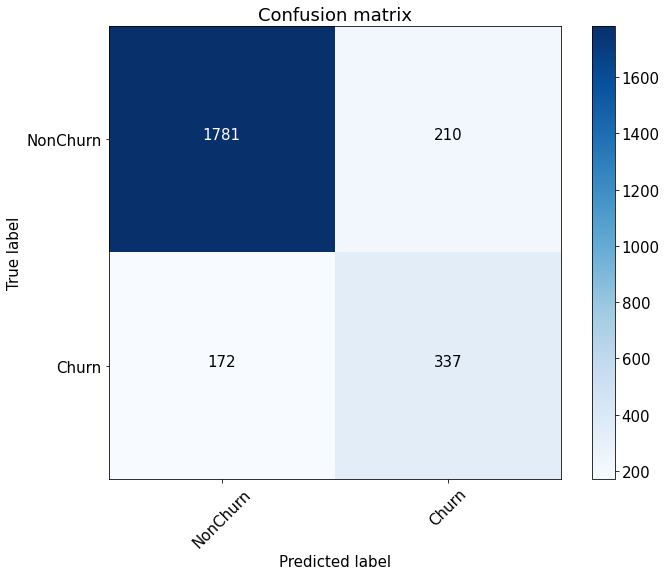

In [23]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [24]:
economy_result = 1 * cnf_matrix[1][1] - 1 * cnf_matrix[0][1]
economy_result
economy_result > 162

False